<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C4W4_ConV_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

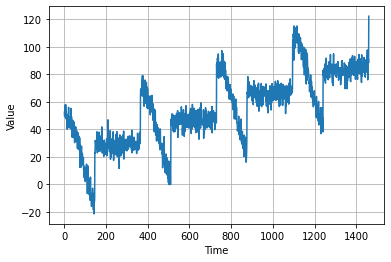

In [3]:
# Set the dataset
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plot_series(time, series)

In [0]:
# Split dataset into training and validation sets
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Set the constans that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Define the windowed_dataset function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Expand 1 dimentional data to Conv1D input data shape
  series = tf.expand_dims(series, axis=1)

  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [0]:
# Define forecasting function
def model_forecast(model, series, window_size):
    # Create a datasets whose elements are slice of series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Window the dataset
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # Mapping a dataset element to a (window_size) batch size dataset
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    # Batch the select batch size
    dataset = dataset.batch(32).prefetch(1)
    # Generate output predictions for the dataset
    forecast = model.predict(dataset)
    
    return forecast

In [14]:
# Clear any internal variables to make easy to experiment w/o models impacting later versions of themselves.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Create the dataset
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Buld the convolutional and LSTM-based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)   
])

# Set the learning rate by callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1,
    callbacks=[lr_schedule]
)

print("Training Complete!")

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 78.0478 - mae: 78.5477 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 77.8921 - mae: 78.3920 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 77.6416 - mae: 78.1415 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 77.3286 - mae: 77.8285 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 76.9622 - mae: 77.4620 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 76.5431 - mae: 77.0430 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 76.0704 - mae: 76.5702 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 75.5364 - mae: 76.0362 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 74.9329 - mae: 75.4327 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

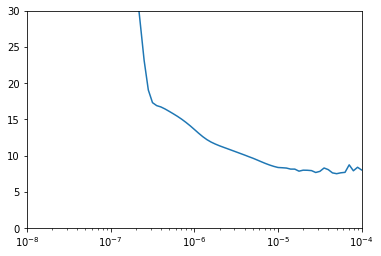

In [15]:
# Plot the loss and check the stable point of learning point
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# Stable point -- 2e-5

In [21]:
# Retrain the model with stable point of learning point
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Create the dataset
# Change batch 
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Buld the convolutional and LSTM-based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)   
])

optimizer = tf.keras.optimizers.SGD(lr=2e-5, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=500,
    verbose=1
)

print("Training Complete!")

Epoch 1/500
8/8 [==============================] - 0s 13ms/step - loss: 42.4624 - mae: 42.9604
Epoch 2/500
8/8 [==============================] - 0s 12ms/step - loss: 22.0504 - mae: 22.5465
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 15.8253 - mae: 16.3185
Epoch 4/500
8/8 [==============================] - 0s 12ms/step - loss: 13.5152 - mae: 14.0066
Epoch 5/500
8/8 [==============================] - 0s 11ms/step - loss: 11.1150 - mae: 11.6055
Epoch 6/500
8/8 [==============================] - 0s 12ms/step - loss: 10.1418 - mae: 10.6295
Epoch 7/500
8/8 [==============================] - 0s 12ms/step - loss: 10.0386 - mae: 10.5269
Epoch 8/500
8/8 [==============================] - 0s 12ms/step - loss: 9.4014 - mae: 9.8885
Epoch 9/500
8/8 [==============================] - 0s 12ms/step - loss: 9.0818 - mae: 9.5682
Epoch 10/500
8/8 [==============================] - 0s 12ms/step - loss: 8.7516 - mae: 9.2363
Epoch 11/500
8/8 [==============================] - 0s 

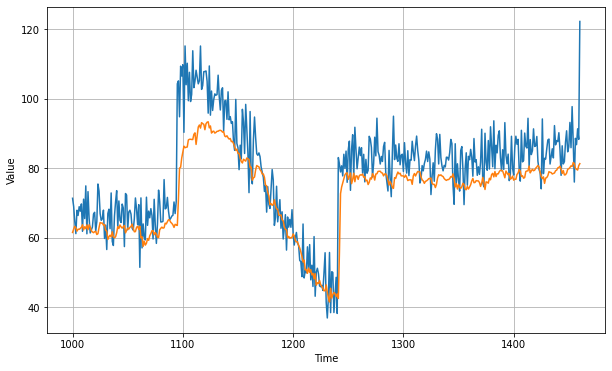

In [22]:
# Forecast every time points of time series
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

# Split results after split time
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# Plot results
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# Actual -- Blue, Prediction -- Orange

In [23]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
# mae = np.abs(errors).mean()

6.900882

<Figure size 432x288 with 0 Axes>

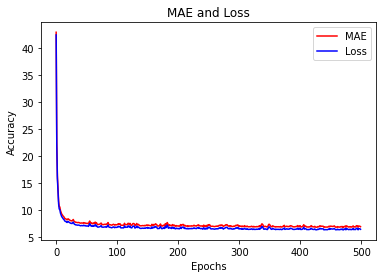

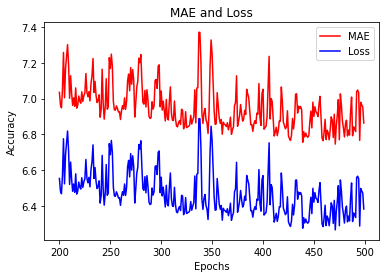

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [25]:
# Retrain the model with mini batch
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Create the dataset
# Change batch size to mini batch size
train_set = windowed_dataset(x_train, window_size, batch_size=16, shuffle_buffer=shuffle_buffer_size)

# Buld the convolutional and LSTM-based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)   
])

optimizer = tf.keras.optimizers.SGD(lr=2e-5, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=500,
    verbose=1
)

print("Training Complete!")

Epoch 1/500
62/62 [==============================] - 1s 12ms/step - loss: 16.9450 - mae: 17.4358
Epoch 2/500
62/62 [==============================] - 1s 12ms/step - loss: 8.6306 - mae: 9.1150
Epoch 3/500
62/62 [==============================] - 1s 12ms/step - loss: 8.4201 - mae: 8.9045
Epoch 4/500
62/62 [==============================] - 1s 12ms/step - loss: 7.7820 - mae: 8.2646
Epoch 5/500
62/62 [==============================] - 1s 12ms/step - loss: 7.9591 - mae: 8.4426
Epoch 6/500
62/62 [==============================] - 1s 12ms/step - loss: 8.9172 - mae: 9.4039
Epoch 7/500
62/62 [==============================] - 1s 12ms/step - loss: 8.0506 - mae: 8.5362
Epoch 8/500
62/62 [==============================] - 1s 12ms/step - loss: 7.6574 - mae: 8.1405
Epoch 9/500
62/62 [==============================] - 1s 12ms/step - loss: 7.2547 - mae: 7.7374
Epoch 10/500
62/62 [==============================] - 1s 12ms/step - loss: 7.3029 - mae: 7.7851
Epoch 11/500
62/62 [===========================

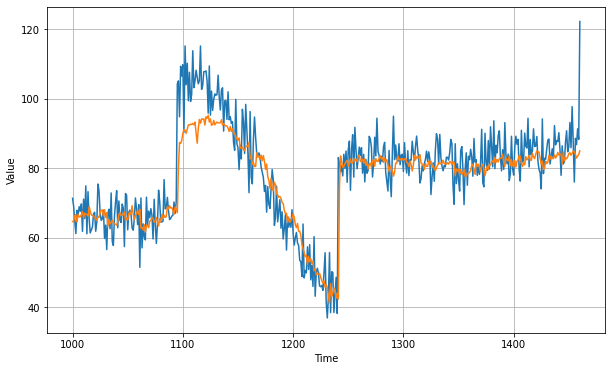

In [26]:
# Forecast every time points of time series
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

# Split results after split time
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# Plot results
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# Actual -- Blue, Prediction -- Orange

In [27]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
# mae = np.abs(errors).mean()

5.3931074